In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
%matplotlib inline
import datetime
import requests
import statsmodels.api as sm
from scipy.stats import kruskal, mannwhitneyu

C:\Users\georg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# 2 Dataset

In [3]:
df = pd.read_csv('data/listings.csv')

C:\Users\georg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.shape

(20769, 106)

# 3 Data Cleaning and Wrangling

## 3.1 Data Type Correction

In [5]:
#String to numeric

col_to_numeric = ['price','security_deposit','cleaning_fee','extra_people']

for col in col_to_numeric:
    df[col] = df[col].str.replace('$','').str.replace(',','').astype(float)

df.host_response_rate = df.host_response_rate.str.replace('%','').astype(float)/100

#String to datetime

col_to_datetime = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']

for col in col_to_datetime:
    df[col] = pd.to_datetime(df[col])

## 3.2 Incorrect Price Data Elimination

In [6]:
#Number of listings with price = 0
df[df.price == 0].shape[0]

4

In [7]:
# Remove listings with price == 0
df = df[df.price > 0]
# Check if listings removed
df[df.price == 0].shape[0], df.shape

(0, (20765, 106))

## 3.3 Missing Values Imputation


In [8]:
size = df.shape[0]
missing_cnt = df.isnull().sum()
missing_pct = missing_cnt/size*100
df_missing = pd.concat([missing_cnt,missing_pct],axis=1)
df_missing.columns = ['Missing Count','Missing Percentage']
df_missing[df_missing['Missing Count']>0].sort_values('Missing Count', ascending=False)

,Missing Count,Missing Percentage
thumbnail_url,20765,100.000000
medium_url,20765,100.000000
host_acceptance_rate,20765,100.000000
neighbourhood_group_cleansed,20765,100.000000
xl_picture_url,20765,100.000000
jurisdiction_names,20763,99.990368
license,20761,99.980737
square_feet,20609,99.248736
monthly_price,18987,91.437515
weekly_price,18678,89.949434


In [9]:
# Save to csv file for report
df_missing[df_missing['Missing Count']>0].sort_values('Missing Count', ascending=False).to_csv('final_report_data/missing_summary.csv')

In [10]:
#Numeric Features (1)
for col in ['host_listings_count','bathrooms','host_response_rate','bedrooms','beds']:
    df[col+'_NA'] = np.where(df[col].isnull(),True, False)
    m = df[col].median()
    df[col].fillna(m,inplace=True)
    
#Numeric Features (2)
for col in ['security_deposit','cleaning_fee']:
    df[col+'_NA'] = np.where(df[col].isnull(),True, False)
    df[col].fillna(0,inplace=True)
    
#Numeric Features (3)
for col in ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']:
    df[col+'_NA'] = np.where(df[col].isnull(),True, False)
    df[col].fillna(df[col].median(),inplace=True)

In [11]:
#Categorical Features
for col in ['host_response_time', 'host_is_superhost','host_identity_verified','host_has_profile_pic']:

    df[col+"_NA"] = np.where(df[col].isnull(),1,0)
    df[col].fillna(df[col].mode().iloc[0],inplace=True)

In [12]:
#Datetime Features
for col in ['host_since', 'first_review', 'last_review']:
    df[col+"_NA"] = np.where(df[col].isnull(),1,0)
    df[col].fillna(df[col].quantile(0.5),inplace=True)

## 3.4 New Feature Creation


### 3.4.1 City Names

In [13]:
# Existing city information
df.neighbourhood.nunique(), df.neighbourhood_cleansed.nunique()

(140, 140)

In [14]:
# Create new column for FSA
df['fsa'] = df.zipcode.str.slice(stop=3).str.upper()

In [15]:
# read in fsa-city data (Wikipedia) 
toronto_fsa = pd.read_csv('final_report_data/toronto_fsa.csv')

#create a dictionary with postcode as key and borough (city) as dictionary
fsa_dict = {i:j for i,j in zip(toronto_fsa.Postcode, toronto_fsa.Borough)}

#create new column that maps the FSA to the city name
df['city_fsa'] = np.nan
df['city_fsa'] = df.fsa.map(fsa_dict)

In [16]:
df.city_fsa.value_counts(dropna=False)

Downtown Toronto    7938
West Toronto        3359
North York          2748
Central Toronto     1426
Scarborough         1358
Etobicoke           1083
East Toronto        1069
York                 707
East York            671
NaN                  376
Thornhill             20
Mississauga            2
Not assigned           2
Pickering              2
Markham                1
Queen's Park           1
Guelph                 1
Kleinburg              1
Name: city_fsa, dtype: int64

In [17]:
# Create a list of indexes for unknown
idx_nan = df.loc[df.city_fsa.isnull() == True].index

# Create list of "Not assigned"
idx_not_assigned = df.loc[df.city_fsa == 'Not assigned'].index

# Create list of rare cities to confirm location with mapquest api
#set threshold to be 1% of all data

threshold = df.shape[0] * 0.01
rare_city_list = df.city_fsa.value_counts()[df.city_fsa.value_counts() < threshold].index
idx_rare = df.loc[df.city_fsa.apply(lambda x: x in rare_city_list)].index

In [18]:
rare_city_list

Index(['Thornhill', 'Mississauga', 'Not assigned', 'Pickering', 'Markham',
       'Queen's Park', 'Guelph', 'Kleinburg'],
      dtype='object')

In [19]:
idx_set = set()
for idx in [idx_nan,idx_not_assigned,idx_rare]:
    idx_set.update(idx)

#convert to list so the order is consistent
idx_list = list(idx_set)

#check listings count
print('Number of listings with unknown FSA or FSA in rare cities is:')
len(idx_list)

Number of listings with unknown FSA or FSA in rare cities is:


406

**Below: Retrieve data from mapquest; performed in milestone report data preparation (not in final report prep)**

In [20]:
##Use Mapquest API
##Only run once on the first run

##key hidden for security reasons

# api_key = "***"

# lat_list = []
# lon_list= []
# fsa_list = []

# for idx in idx_list:
#     lat = df.loc[idx].latitude
#     lon = df.loc[idx].longitude
#     url = "http://www.mapquestapi.com/geocoding/v1/reverse?key=" + api_key + "&location=" + str(lat) + "," + str(lon)
#     r = requests.get(url)
#     fsa = r.json()['results'][0]['locations'][0]['postalCode'][:3]
#     lat_list.append(lat)
#     lon_list.append(lon)
#     fsa_list.append(fsa)

In [21]:
# city_rev_geocode_df = pd.DataFrame({'latitude':lat_list,'longitude':lon_list,'fsa':fsa_list},index=idx_list)
# city_rev_geocode_df['city'] = np.nan
# city_rev_geocode_df['city'] = city_rev_geocode_df.fsa.map(fsa_dict)
# city_rev_geocode_df.to_csv('data/city_rev_geocode_df.csv')

In [22]:
file = 'data/city_rev_geocode_df.csv'
city_rev_geocode_df = pd.read_csv(file, index_col=0)
city_rev_geocode_df.city.value_counts(dropna=False)

Downtown Toronto    200
North York           48
West Toronto         48
Etobicoke            23
Central Toronto      22
East Toronto         18
Scarborough          18
York                  8
Thornhill             7
East York             7
Mississauga           2
Pickering             2
NaN                   2
Markham               1
Name: city, dtype: int64

In [23]:
city_rev_geocode_df.shape[0]

406

In [24]:
#impute df city_fsa information with api collected data

file = 'data/city_rev_geocode_df.csv'
city_rev_geocode_df = pd.read_csv(file, index_col=0)
for idx in city_rev_geocode_df.index:
    df.loc[idx,'fsa'] = city_rev_geocode_df.loc[idx,'fsa']
    df.loc[idx,'city_fsa'] = city_rev_geocode_df.loc[idx,'city']

In [25]:
df.city_fsa.value_counts(dropna=False)

Downtown Toronto    8138
West Toronto        3407
North York          2796
Central Toronto     1448
Scarborough         1376
Etobicoke           1106
East Toronto        1087
York                 715
East York            678
Thornhill              7
Pickering              2
Mississauga            2
NaN                    2
Markham                1
Name: city_fsa, dtype: int64

In [26]:
#Drop Minority City
city_list = ['Downtown Toronto','Central Toronto','East Toronto','West Toronto','York','North York','East York','Scarborough','Etobicoke']
city_filter = df.city_fsa.apply(lambda x: x in city_list)
df = df.loc[city_filter]

In [27]:
df.shape[0]

20751

In [28]:
df.city_fsa.value_counts()/df.shape[0]

Downtown Toronto    0.392174
West Toronto        0.164185
North York          0.134740
Central Toronto     0.069780
Scarborough         0.066310
Etobicoke           0.053299
East Toronto        0.052383
York                0.034456
East York           0.032673
Name: city_fsa, dtype: float64

### 3.4.2 Indicator Variable for Amenities

In [29]:
df['amenities_list'] = df['amenities'].str.lower().str.replace('[{}"]','').str.split(',')
amenities_set = set()
for i in df['amenities_list']:
    amenities_set.update(i)
amenities_set.remove('')
for item in amenities_set:
    df[item] = df.amenities_list.apply(lambda x: 1 if item in x else 0)

In [30]:
len(amenities_set)

196

In [31]:
size = df.shape[0]
count = []
pct = []
for item in amenities_set:
    count.append(df[item].sum())
    pct.append(df[item].sum()/size*100)
amenities_counts = pd.DataFrame({'Count':count,"Percentage of Listings":pct},index = amenities_set).sort_values(by='Count')

In [32]:
# save to file for report
amenities_counts.to_csv('final_report_data/amenities_count.csv')

In [33]:
#Rarest Amenities
amenities_counts.head()

,Count,Percentage of Listings
brick oven,1,0.004819
tennis court,1,0.004819
hammock,1,0.004819
pool toys,1,0.004819
mobile hoist,2,0.009638


In [34]:
#Most Common Amenities
amenities_counts.tail()

,Count,Percentage of Listings
kitchen,19127,92.173871
smoke detector,19520,94.067756
essentials,19736,95.108669
heating,20091,96.819430
wifi,20366,98.144668


In [35]:
amenities_counts.loc['hot water']

Count                     12253.000000
Percentage of Listings       59.047757
Name: hot water, dtype: float64

In [36]:
# remove amenities list feature here
df.drop('amenities_list', axis=1,inplace=True)

### 3.4.3 Verification Count

In [37]:
df['host_verification_sum']=df.host_verifications.apply(lambda x: len(x.strip('[]').split(', ')))

### 3.4.4 Days since events

In [38]:
ref_date = datetime.datetime(2019,6,27)

In [39]:
dt_col = ['host_since','first_review','last_review']
for col in dt_col:
    df['days_since'+col] = df[col].apply(lambda x: (ref_date - x).days)

# 4 Data Exploration

## 4.1 Price

In [40]:
df.price.describe()

count    20751.000000
mean       143.349766
std        234.243598
min         13.000000
25%         64.000000
50%        101.000000
75%        160.000000
max      13422.000000
Name: price, dtype: float64

In [41]:
df.loc[df.price == 13422, 'listing_url']

6263    https://www.airbnb.com/rooms/16039481
Name: listing_url, dtype: object

In [42]:
# Create price cutoff as 99th percentile of price data
price_cap = np.percentile(df.price, 99)
price_cap

750.0

In [43]:
#cap price and check
df = df[df.price <= price_cap]
df.price.describe()

count    20544.000000
mean       129.919782
std        100.365287
min         13.000000
25%         64.000000
50%        101.000000
75%        159.000000
max        750.000000
Name: price, dtype: float64

In [44]:
df['log_price'] = np.log(df.price)

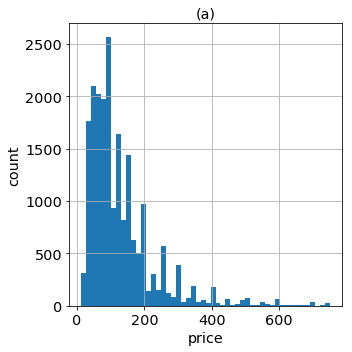

In [45]:
df.price.hist(bins=50)
plt.xlabel('price')
plt.ylabel('count')
plt.title('(a)');
plt.tight_layout();
plt.savefig("final_report_figures/price_hist.png")

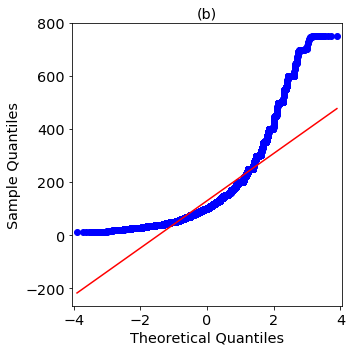

In [46]:
sm.qqplot(df.price,line='r')
plt.title('(b)')
plt.tight_layout()
plt.savefig('final_report_figures/price_QQ')

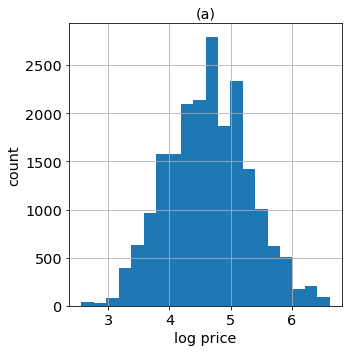

In [47]:
df.log_price.hist(bins=20)
plt.xlabel('log price')
plt.ylabel('count')
plt.title('(a)');
plt.tight_layout();
plt.savefig("final_report_figures/log_price_hist.png")

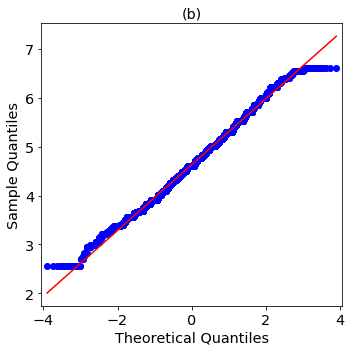

In [48]:
sm.qqplot(df.log_price,line='r')
plt.title('(b)')
plt.tight_layout()
plt.savefig('final_report_figures/log_price_QQ.png')

## 4.2 Geographical Information

In [49]:
df.city_fsa.value_counts(dropna=False)

Downtown Toronto    8026
West Toronto        3385
North York          2772
Central Toronto     1422
Scarborough         1370
Etobicoke           1102
East Toronto        1081
York                 712
East York            674
Name: city_fsa, dtype: int64

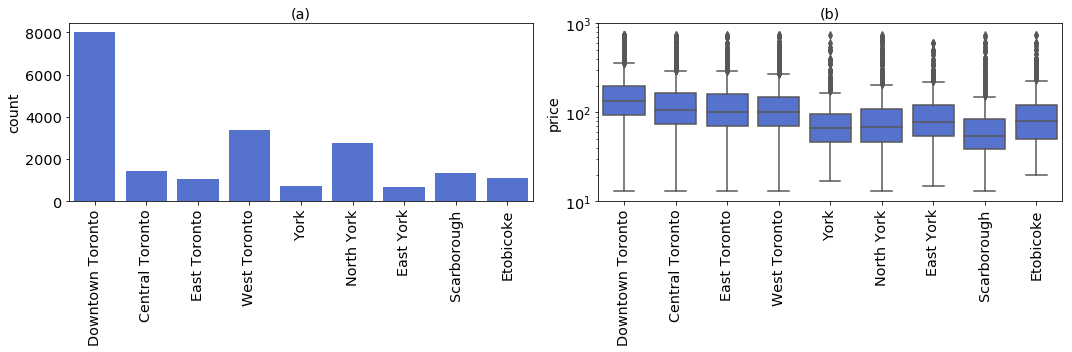

In [50]:
city_order = ['Downtown Toronto','Central Toronto','East Toronto','West Toronto','York','North York','East York',
              'Scarborough','Etobicoke']
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='city_fsa',order=city_order,color='royalblue')
plt.xlabel("")
plt.xticks(rotation=90)
plt.title('(a)')
plt.subplot(1,2,2)
sns.boxplot(data=df, x='city_fsa',y='price', order=city_order,color='royalblue')
plt.yscale('log')
plt.ylim([10,1000])
plt.xlabel("")
plt.ylabel("price")
plt.xticks(rotation=90)
plt.title('(b)')
plt.tight_layout()
plt.savefig("final_report_figures/region.png");

## 4.3 Property Information

### 4.3.1 Property Type

In [51]:
# Create a function for count and percentage for categorical variables

def count_pct(variable, data=df):
    idx = data[variable].value_counts().index
    count_pct_dict = {'count': data[variable].value_counts(dropna=False).values,
                      'pct':data[variable].value_counts(dropna=False).values/data.shape[0]*100}
    return pd.DataFrame(count_pct_dict,index=idx)

In [52]:
property_type_counts = count_pct(variable = 'property_type')
property_type_counts

,count,pct
Apartment,6123,29.804322
Condominium,5441,26.484618
House,5415,26.358061
Townhouse,954,4.643692
Guest suite,795,3.869743
Bungalow,675,3.285631
Loft,439,2.136877
Serviced apartment,215,1.046534
Guesthouse,109,0.530569
Bed and breakfast,102,0.496495


In [53]:
len(df.property_type.unique()), (property_type_counts['count'] <= 10).sum()

(30, 16)

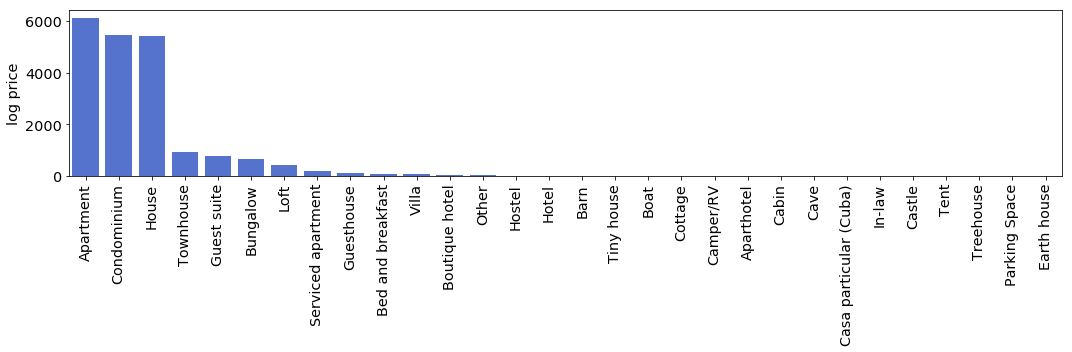

In [54]:
# create and index so for ordering the boxplots according to counts
plt.figure(figsize=(15,5))

idx = df.property_type.value_counts().index
sns.countplot(data=df, x='property_type', order=idx,color='royalblue')
#plt.xlabel("property type")
plt.ylabel('log price')
plt.xticks(rotation=90)
plt.xlabel('')
plt.tight_layout()
plt.savefig("final_report_figures/bar_property_type.png");

In [55]:
# Assign Bungalow as House per Wikipedia
df.loc[df.property_type == 'Bungalow','property_type'] = 'House'

In [56]:
# Assign Other to minority property types

threshold = 0.05
size = df.shape[0]
filter_ = df.property_type.value_counts() > threshold * size
property_type_included = df.property_type.value_counts()[filter_].index
df['property_type_simple'] = df.property_type.apply(lambda x: 'Other' if x not in property_type_included else x)

''

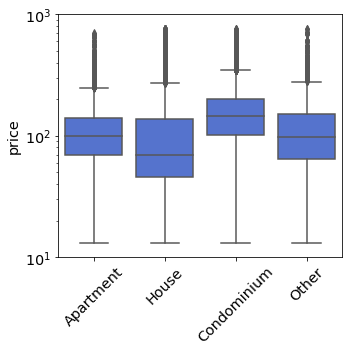

In [57]:
order = df['property_type_simple'].value_counts().index

plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='property_type_simple',y='price', order=order,color='royalblue')
plt.xlabel("")
plt.ylabel("price")
plt.yscale('log')
plt.ylim([10,1000])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("final_report_figures/property_type_box.png")
;

### 4.3.2 Room Type

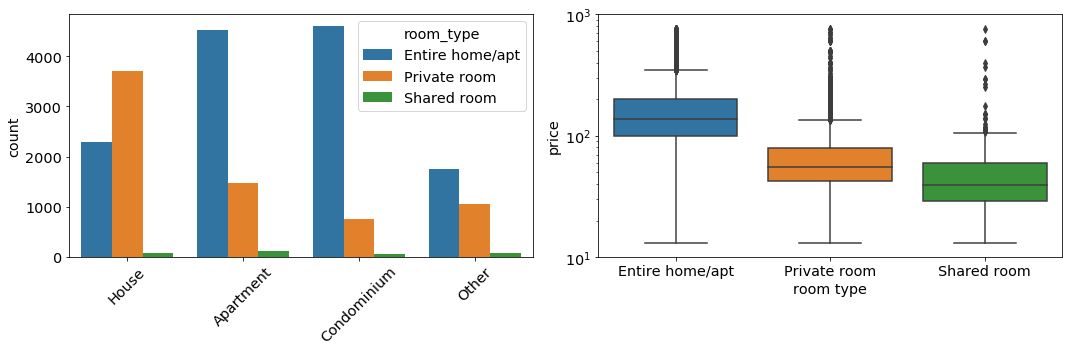

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='property_type_simple',hue='room_type')
plt.xlabel('')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.boxplot(data=df,y='price',x='room_type')
plt.xlabel('room type')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.tight_layout()
plt.savefig("final_report_figures/room_type_bar_box.png");

### 4.3.3 Property Features

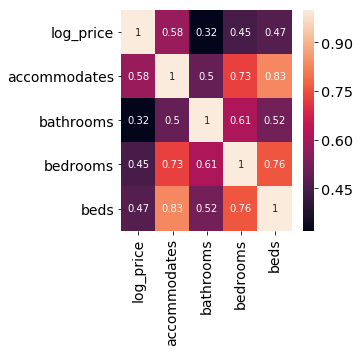

In [59]:
plt.figure(figsize=(5,5))
corr_matrix = df[['log_price','accommodates', 'bathrooms', 'bedrooms', 'beds']].corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('final_report_figures/corr_matrix_features.png');

### 4.3.4 Amenities

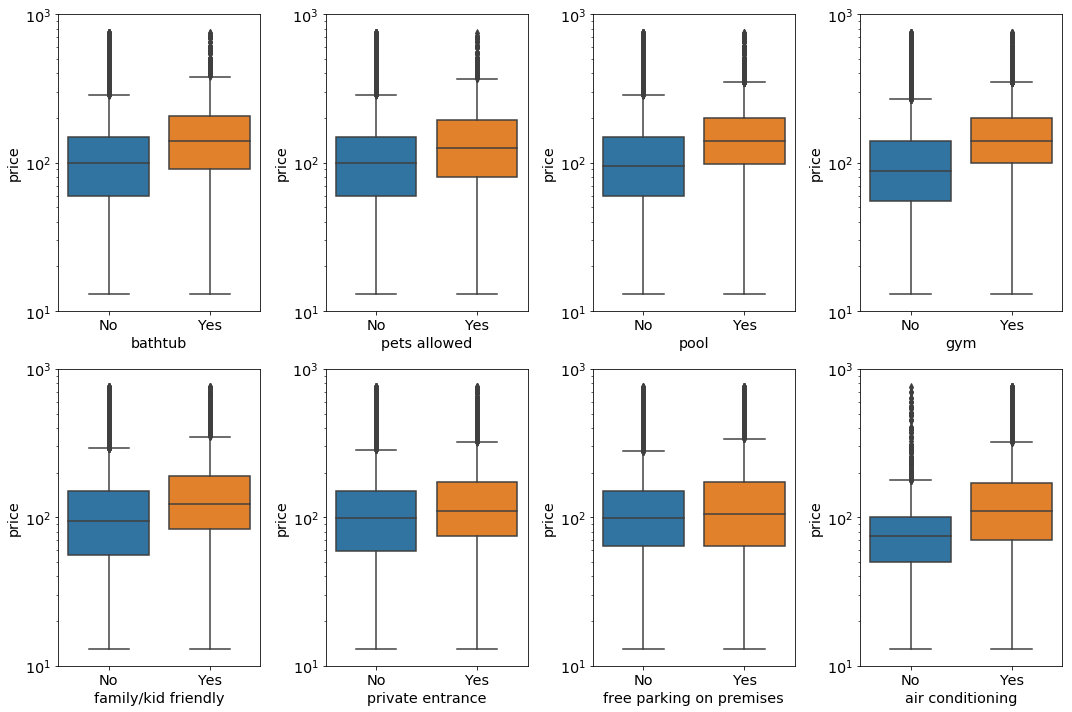

In [60]:
amenities_test = ['bathtub','pets allowed','pool','gym','family/kid friendly',
                  'private entrance', 'free parking on premises', 'air conditioning']

plt.figure(figsize=(15,10))
for i, item in enumerate(amenities_test,1):
    plt.subplot(2,4,i)
    sns.boxplot(data=df, x=item, y='price',order=[0,1])
    plt.xlabel(item)
    plt.ylabel('price')
    plt.yscale('log')
    plt.ylim([10,1000])
    plt.xticks([0,1],['No','Yes'])
plt.tight_layout()
plt.savefig('final_report_figures/amenities_box.png')

## 4.4 Host Information

### 4.4.1 Superhost status

In [61]:
df.host_is_superhost.value_counts(dropna=False)/df.shape[0]

f    0.738318
t    0.261682
Name: host_is_superhost, dtype: float64

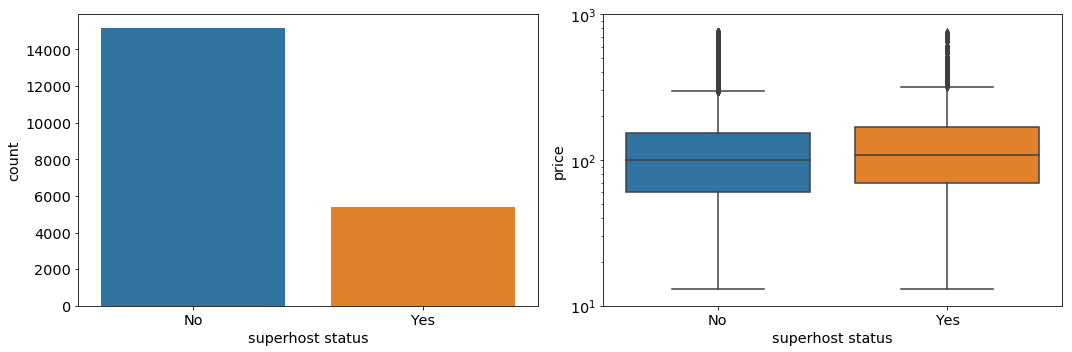

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='host_is_superhost')
plt.xlabel('superhost status')
plt.xticks([0,1],['No','Yes'])
plt.subplot(1,2,2)
sns.boxplot(data=df, x='host_is_superhost', y='price')
plt.xticks([0,1],['No','Yes'])
plt.xlabel('superhost status')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.tight_layout()
plt.savefig('final_report_figures/superhost_count_box.png');

## 4.5 Booking Policy

### 4.5.1 Cleaning fee

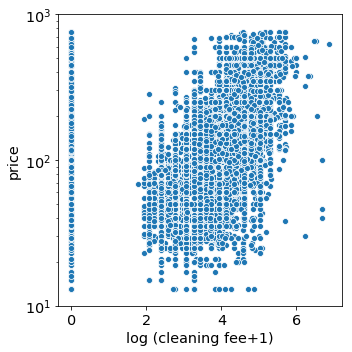

In [63]:
df['log_cleaning_fee'] = np.log(df.cleaning_fee + 1)

sns.scatterplot(x='log_cleaning_fee',y='price',data=df)
plt.xlabel('log (cleaning fee+1)')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.tight_layout()
plt.savefig('final_report_figures/logcleaningfee_price')

df.drop('log_cleaning_fee',axis=1,inplace=True)

### 4.5.2 Minimum Nights of stay

In [64]:
df['minimum_nights_category'] = df.minimum_nights.apply(lambda x: "1 day" if x ==1 
                                                        else ("2 days" if x ==2 
                                                              else("3 days" if x ==3
                                                                   else ("4 to 7 days" if x <=7 
                                                                         else ">7 days"))))

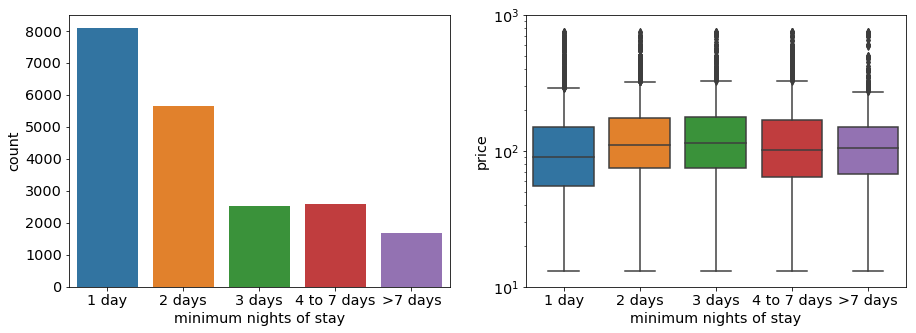

In [65]:
order = ["1 day","2 days", "3 days", "4 to 7 days", ">7 days"]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='minimum_nights_category',order=order)
plt.xlabel('minimum nights of stay')
plt.subplot(1,2,2)
sns.boxplot(data=df, x='minimum_nights_category', y='price',order=order)
plt.xlabel('minimum nights of stay')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.savefig('final_report_figures/min_night.png');

In [66]:
df.minimum_nights_category.value_counts()/df.shape[0]

1 day          0.394081
2 days         0.274971
4 to 7 days    0.125779
3 days         0.123248
>7 days        0.081922
Name: minimum_nights_category, dtype: float64

In [67]:
df.drop('minimum_nights_category',axis=1,inplace=True)

### 4.5.3 Other Numerical Features

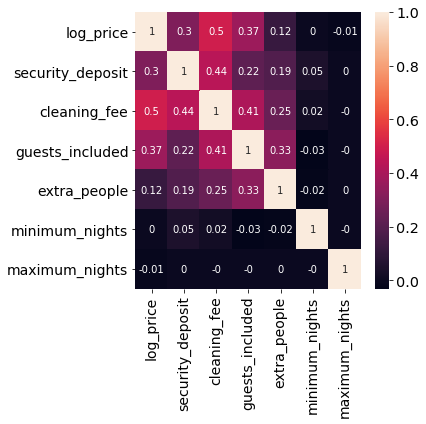

In [68]:
corr_matrix = df[['log_price','security_deposit', 'cleaning_fee','guests_included', 'extra_people',
                  'minimum_nights', 'maximum_nights']].corr().round(2)
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix, annot=True)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('final_report_figures/booking_num_corr.png');

## 4.6 Availability

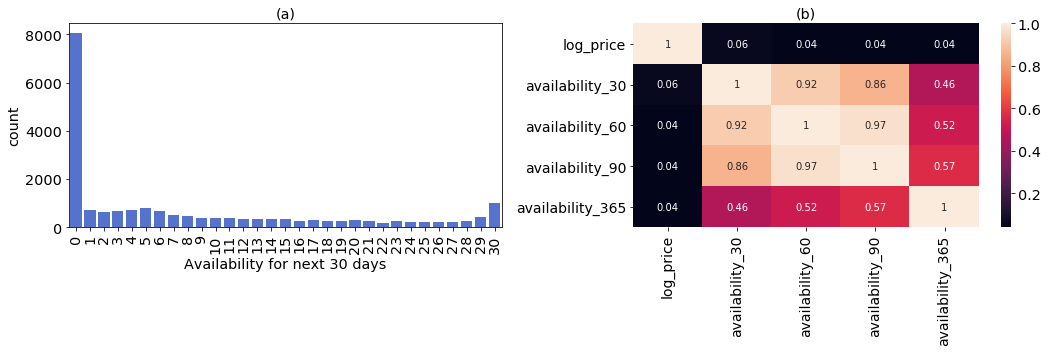

In [260]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='availability_30', color='royalblue')
plt.xticks(rotation=90)
plt.xlabel('Availability for next 30 days')
plt.title('(a)')
plt.subplot(1,2,2)

corr_matrix = df[['log_price','availability_30', 'availability_60', 'availability_90', 'availability_365']].corr().round(2)
sns.heatmap(corr_matrix,annot=True)
plt.tick_params(labelsize=14)
plt.title('(b)')

plt.tight_layout()
plt.savefig('final_report_figures/availibility_corr.png');

# 4.7 Reviews


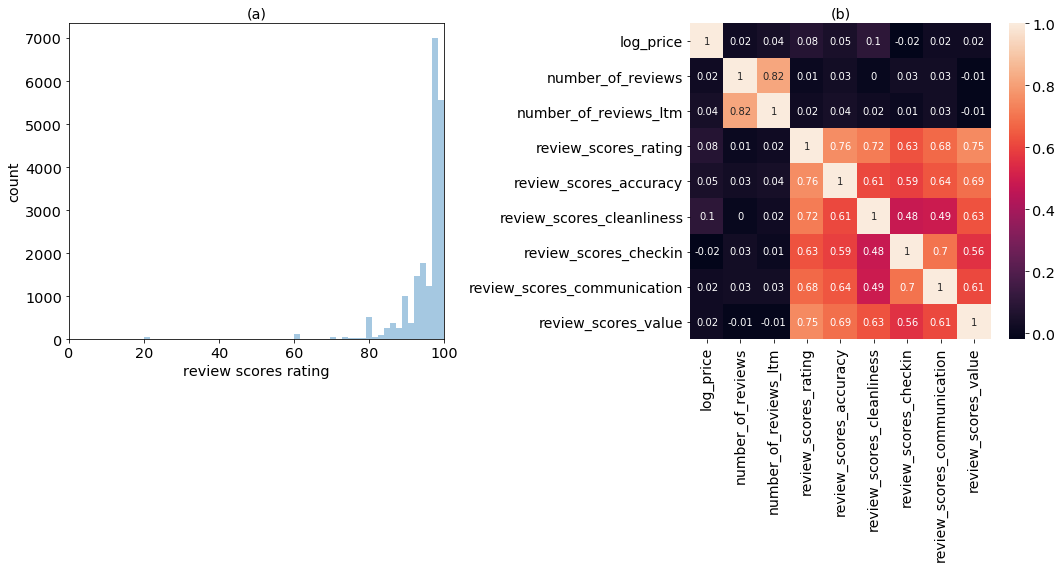

In [267]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
sns.distplot(df.review_scores_rating,kde=False)
plt.xlim(0,100)
plt.xlabel('review scores rating')
plt.ylabel('count')
plt.title('(a)')
plt.subplot(1,2,2)
corr_matrix = df[['log_price','number_of_reviews','number_of_reviews_ltm','review_scores_rating', 'review_scores_accuracy', 
                  'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                  'review_scores_value']].corr().round(2)

sns.heatmap(corr_matrix,annot=True)
plt.tick_params(labelsize=14)
plt.title('(b)')
plt.tight_layout()
plt.savefig('final_report_figures/review_corr.png')

## 4.8 Statistical Analysis of Categorical Features

In [71]:
def pop_eval(feature_list,threshold = 20):

    for feature in feature_list:
        filter_ = (df[feature].value_counts() > threshold)
        data_list = []
        var_str = ""
        cat_list = df[feature].value_counts()[filter_].index
        for i, cat in enumerate(cat_list):
            data_list.append(list(df.loc[df[feature] == cat, 'log_price'].values))
            var_str = var_str + 'data_list' + "[" + str(i) + "]" + ", "
        var_str = var_str[:-2]
        if len(cat_list) > 2:
            s, p = eval('kruskal(' + var_str + ')')
        elif len(cat_list) == 2:
            s, p = eval('mannwhitneyu('+ var_str + ')')
            
        print(f'Feature: {feature}')
        print(f'Categories: {list(cat_list)}')
        if len(cat_list) ==1:
            print(f'Only one category has count above the threshold of {threshold}. No test was performed.')
            break
        if len(cat_list) > 2:
            print('Test: Kruskal-Wallis Test')
        elif len(cat_list) == 2:
            print('Test: Mann Whitney U Test')
        print(f'The test statistics is {s} and the p-value is {p}.')
        if p < 0.05:
            print('Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.')
        else:
            print('Null hypothesis NOT rejected. There is not significant evidence the samples are not from the same distribution.')
        print('\n')

In [72]:
pop_eval(['property_type_simple', 'room_type', 'bed_type', 'city_fsa'])

Feature: property_type_simple
Categories: ['Apartment', 'House', 'Condominium', 'Other']
Test: Kruskal-Wallis Test
The test statistics is 2391.5515809371573 and the p-value is 0.0.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: room_type
Categories: ['Entire home/apt', 'Private room', 'Shared room']
Test: Kruskal-Wallis Test
The test statistics is 8748.292987221765 and the p-value is 0.0.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: bed_type
Categories: ['Real Bed', 'Futon', 'Pull-out Sofa', 'Airbed', 'Couch']
Test: Kruskal-Wallis Test
The test statistics is 113.5821627127607 and the p-value is 1.2525860377882579e-23.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: city_fsa
Categories: ['Downtown Toronto', 'West Toronto', 'North York', 'Central Toronto', 'Scarborough', 'Et

In [73]:
pop_eval(['cancellation_policy','instant_bookable','is_business_travel_ready'])

Feature: cancellation_policy
Categories: ['strict_14_with_grace_period', 'moderate', 'flexible', 'super_strict_30']
Test: Kruskal-Wallis Test
The test statistics is 679.9027904515203 and the p-value is 4.78394048145418e-147.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: instant_bookable
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 45366984.5 and the p-value is 1.0586762305363768e-32.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: is_business_travel_ready
Categories: ['f']
Only one category has count above the threshold of 20. No test was performed.


In [74]:
pop_eval(['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified'])

Feature: host_response_time
Categories: ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
Test: Kruskal-Wallis Test
The test statistics is 32.99253737405885 and the p-value is 3.2323673165314957e-07.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_is_superhost
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 38001571.0 and the p-value is 6.095919698286464e-14.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_has_profile_pic
Categories: ['t', 'f']
Test: Mann Whitney U Test
The test statistics is 449167.0 and the p-value is 0.01475280329914592.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_identity_verified
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 47471623.5 and the p-value is 7.08

In [75]:
amenities_list = list(amenities_set)
lower = df.shape[0] * 0.1
upper = df.shape[0] * 0.9
filter_ = (df[amenities_list].sum() <=  upper) & (df[amenities_list].sum() >=  lower)
amenities_test = df[amenities_list].sum()[filter_].index

In [76]:
pop_eval(amenities_test)

Feature: hot tub
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 18497004.0 and the p-value is 5.6230549982773676e-167.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: laptop friendly workspace
Categories: [1, 0]
Test: Mann Whitney U Test
The test statistics is 36210667.0 and the p-value is 3.2217915609711518e-18.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: dishes and silverware
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 45190829.5 and the p-value is 1.5692836519616152e-49.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: air conditioning
Categories: [1, 0]
Test: Mann Whitney U Test
The test statistics is 17613639.0 and the p-value is 5.976654050725502e-188.
Null hypothesis rejected. There is significant evidence the not all samp

Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: microwave
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 46959170.0 and the p-value is 1.079289469822587e-25.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: safety card
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 22006993.5 and the p-value is 7.129708059449049e-11.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host greets you
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 25703109.0 and the p-value is 9.686068619571672e-13.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: luggage dropoff allowed
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 31983118.5 and the p-value is 0

# Data preprocessing prior to machine learning

## Change binary variables datatype from string to numeric


In [77]:
for col in ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','has_availability',
            'requires_license','instant_bookable','is_business_travel_ready','require_guest_profile_picture',
            'require_guest_phone_verification']:
    df[col] = df[col].map({'t':1,'f':0})

## Irrelevant Feature Removal 

**Excessive Missing Values**

In [78]:
features_to_remove = set()

missing_features = list(df_missing.loc[df_missing['Missing Percentage'] > 50].index)
features_to_remove.update(missing_features)

In [79]:
print(missing_features)

['notes', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names']


**Text Features**

In [80]:
text_features = ['name','summary','space','description','neighborhood_overview','transit','access','interaction',
                'house_rules','host_verifications']
features_to_remove.update(text_features)

**Webscraping Information**

In [81]:
webscrapping_features = ['id','scrape_id','last_scraped','calendar_last_scraped','calendar_updated']
features_to_remove.update(webscrapping_features)

**Airbnb listing information and host personal information**

In [82]:
listing_host_features = ['listing_url','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url',
                         'host_name','host_location','host_about','host_thumbnail_url','host_picture_url',
                         'host_neighbourhood','host_total_listings_count']
features_to_remove.update(listing_host_features)

**Redundant information**

In [83]:
redundant_features = ['street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','city','state',
                     'zipcode','market','smart_location','country_code','country','latitude','longitude','amenities',
                      'first_review','last_review','host_since','fsa', 'property_type']
features_to_remove.update(redundant_features)

**Reference information**

In [84]:
reference_features = ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                     'minimum_nights_avg_ntm','maximum_nights_avg_ntm','calculated_host_listings_count', 
                      'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
                      'calculated_host_listings_count_shared_rooms']
features_to_remove.update(reference_features)

**Features with single value**

In [85]:
single_value_features = []

for col in df.columns:
    if df[col].nunique() == 1:
        single_value_features.append(col)
        print(col)
features_to_remove.update(single_value_features)

scrape_id
experiences_offered
country_code
country
has_availability
requires_license
license
is_business_travel_ready


In [86]:
df.drop(features_to_remove,axis =1, inplace = True)

In [87]:
df.shape

(20544, 263)

## Create Dummy Variables

We create dummy variables for all categorical features.

In [88]:
df = pd.get_dummies(df, drop_first=False)

In [89]:
df.shape

(20544, 287)

# 5. Machine Learning Model 

## 5.1  Data preprocessing

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Here we split the data into the training and test sets, with test size of 0.25.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['log_price','price'],axis=1), 
                                                    df.log_price, test_size=0.25, random_state=1) 

Then, we create a scaler to normalize the training data and use the same scaler to scale the test data.  

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5.3 Linear Regression Model

In [93]:
lm = LinearRegression()

In [94]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [210]:
lm_pred_train = lm.predict(X_train)

lm_residual_train = y_train - lm_pred_train
lm_PE_train = np.divide((y_train - lm_pred_train), y_train) *100

metrics_lm_train = ['Train R2',  'Train RMSE','Train AMPE']

lm_train_results = [lm.score(X_train, y_train),
                         np.sqrt(mean_squared_error(y_train, lm_pred_train)),
                         np.mean(np.abs(lm_PE_train))]

for metric, result in zip(metrics_lm_train,lm_train_results):
    print(f'{metric}: {result}')

print()
    
lm_pred_test = lm.predict(X_test)

lm_residual = y_test - lm_pred_test
lm_PE_test = np.divide((y_test - lm_pred_test), y_test) *100

    
metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    

lm_test_results = [lm.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, lm_pred_test)),
                  np.mean(np.abs(lm_PE_test))]

for metric, result in zip(metrics_test,lm_test_results):
    print(f'{metric}: {result}')
    


Train R2: 0.6845715449398637
Train RMSE: 0.37951383333287003
Train AMPE: 6.355002936601767

Test R^2: 0.6541341621511894
Test RMSE: 0.39581219340489715
Test AAPE: 6.538311237198936


In [211]:
# Get model performance with unlogged result

lm_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(lm_results_test.predicted), np.exp(y_test)) *100

metrics = ['Test R^2', 'Test RMSE', "Test AAPE"]

lm_test_results_unlog = [r2_score(np.exp(y_test), np.exp(lm_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lm_pred_test))), 
                         np.mean(np.abs(lm_PE_test_unlog))]

for metric, result in zip(metrics_test, lm_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.4680814934853643
Test RMSE: 73.74129603318701
Test AAPE: 32.19519021270757


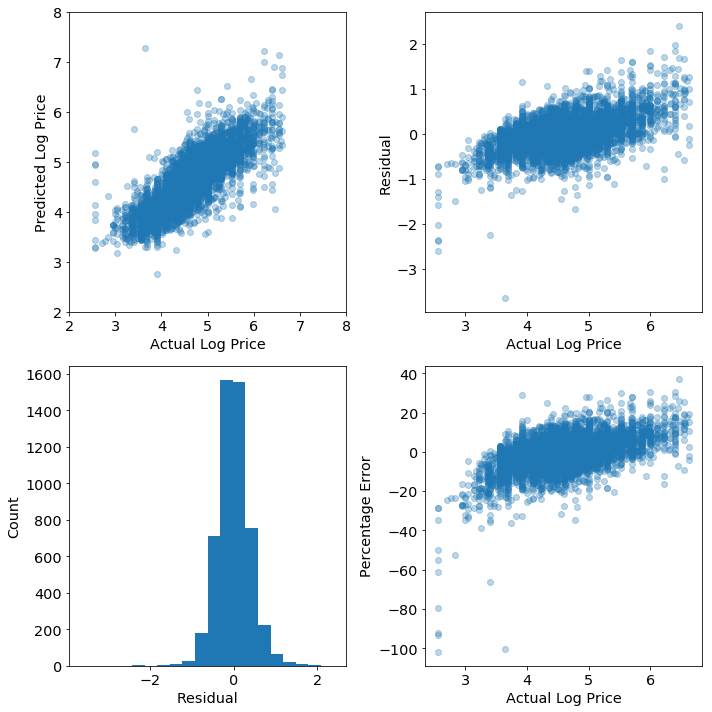

In [212]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,lm_pred_test, alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,lm_residual, alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(lm_residual, bins= 20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, lm_PE_test, alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
#plt.suptitle('Linear Model Performance',y = 1.05,size=20)
plt.tight_layout()
#plt.show()
plt.savefig('final_report_figures/lm_diagnostics.png')

## 5.4 Random Forest

In [214]:
from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict

In [31]:
RANDOM_STATE = 10
N_ESTIMATORS = 1000
ensemble_models = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators= N_ESTIMATORS,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators = N_ESTIMATORS,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(n_estimators = N_ESTIMATORS,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))]

oob_r2_dict = OrderedDict((label,[]) for label, _ in ensemble_models)

min_estimators = 50
max_estimators = N_ESTIMATORS

for label, model in ensemble_models:
    for i in range(min_estimators, max_estimators + 1):
        model.set_params(n_estimators = i)
        model.fit(X_train,y_train)
        
        oob_r2 = model.oob_score_

        oob_r2_dict[label].append((i,oob_r2))

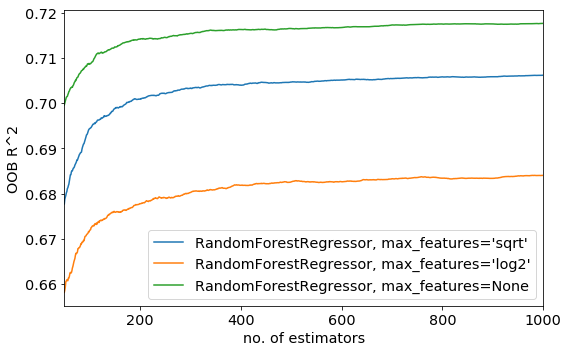

In [803]:
plt.figure(figsize=(8,5))

for label, model_r2 in oob_r2_dict.items():
    xs, ys = zip(*model_r2)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("no. of estimators")
plt.ylabel("OOB R^2")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('final_report_figures/rf_oob_1000.png')
plt.show()

In [215]:
RANDOM_STATE = 10
rf = RandomForestRegressor(max_features=None,n_estimators=300, random_state = RANDOM_STATE)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [216]:
rf_pred_test = rf.predict(X_test)

rf_residual = y_test - rf_pred_test
rf_PE_test = np.divide((y_test - rf_pred_test), y_test) *100


rf_test_results = [rf.score(X_test, y_test),np.sqrt(mean_squared_error(y_test, rf_pred_test)),
                  np.mean(np.abs(rf_PE_test))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,rf_test_results):
    print(f'{metric}: {result}')


Test R^2: 0.7077730450687032
Test RMSE: 0.3638274574763842
Test AAPE: 5.87143928982371


In [217]:
rf_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(rf_pred_test), np.exp(y_test)) *100

rf_test_results_unlog = [r2_score(np.exp(y_test), np.exp(rf_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(rf_pred_test))), 
                         np.mean(np.abs(rf_PE_test_unlog))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,rf_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.6064479910195884
Test RMSE: 63.42920714316619
Test AAPE: 28.570637358535834


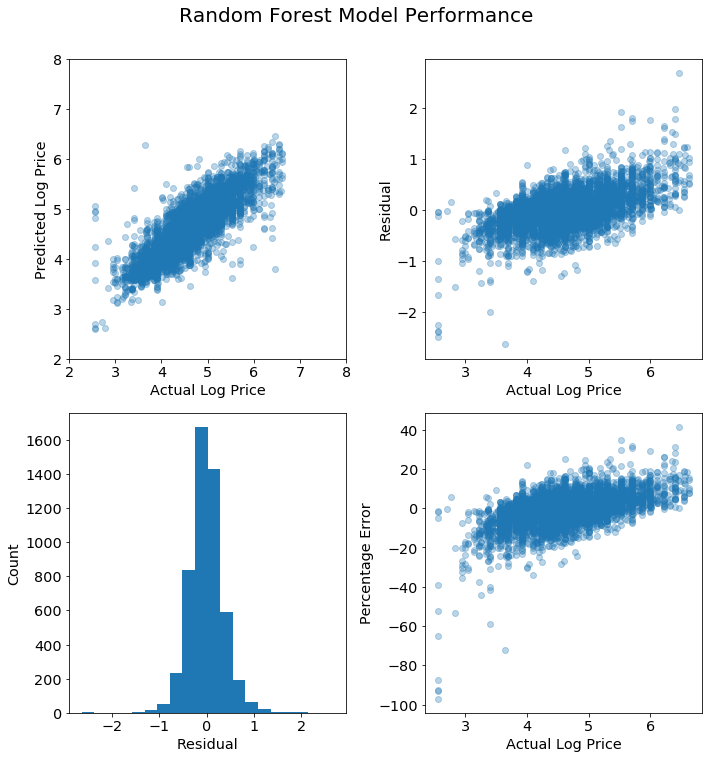

In [218]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,rf_pred_test, alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,rf_residual,alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(rf_residual, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, rf_PE_test,alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('Random Forest Model Performance',y = 1.05, size=20)
plt.tight_layout()
plt.savefig('final_report_figures/rf_diags.png')
plt.show()

In [98]:
import seaborn as sns

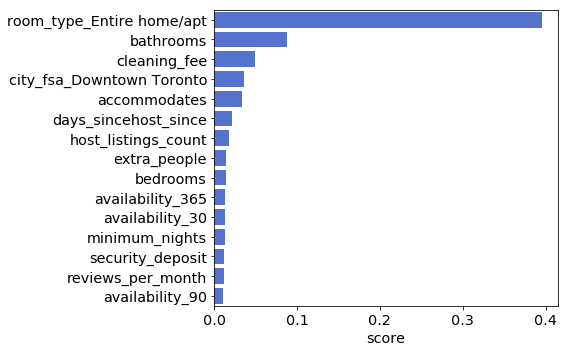

In [219]:
#n_estimator = 300 (new)
rf_feature_importances = pd.DataFrame({'score':rf.feature_importances_,
                                      'feature': df.drop(['price','log_price'],axis=1).columns})
rf_feature_importances = rf_feature_importances.sort_values('score',ascending=False)[:15]

plt.figure(figsize=(8,5))
sns.barplot(data = rf_feature_importances,y='feature',x='score',color='royalblue')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_report_figures/rf_feat_importance.png');

In [109]:
rf_feature_importances['index']

0     room_type_Entire home/apt
1                     bathrooms
2                  cleaning_fee
3     city_fsa_Downtown Toronto
4                  accommodates
5          days_sincehost_since
6           host_listings_count
7                  extra_people
8                      bedrooms
9              availability_365
10              availability_30
11               minimum_nights
12             security_deposit
13            reviews_per_month
14              availability_90
15       days_sincefirst_review
16        days_sincelast_review
17              availability_60
18               maximum_nights
19        host_verification_sum
Name: index, dtype: object

## 3.5 Gradient boosting

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import datetime

In [107]:
## Grid Search with CV
RANDOM_STATE = 10

gb = GradientBoostingRegressor(warm_start = True, random_state = RANDOM_STATE)
param_grid = {'learning_rate':[0.01 ,0.1, 1], 'n_estimators':[100, 300, 500],
              'max_depth': [2, 5], 'max_features' :[None, 'sqrt','log2']}
cv_gb = GridSearchCV(estimator=gb,param_grid=param_grid,cv=5)

gb_cv_start_time = datetime.datetime.now()
cv_gb.fit(X_train,y_train)
gb_cv_end_time = datetime.datetime.now()

In [109]:
(gb_cv_start_time,gb_cv_end_time)

(datetime.datetime(2019, 8, 30, 5, 23, 38, 781835),
 datetime.datetime(2019, 8, 30, 7, 14, 45, 809177))

In [108]:
gb_best_params = cv_gb.best_params_
gb_best_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 300}

In [220]:
pd.DataFrame(OrderedDict({'learning_rate': cv_gb.cv_results_['param_learning_rate'],
'max_depth':cv_gb.cv_results_['param_max_depth'],
'max_features':cv_gb.cv_results_['param_max_features'],
'n_estimators':cv_gb.cv_results_['param_n_estimators'],
"mean_test_score":cv_gb.cv_results_['mean_test_score']})).to_csv('final_report_data/gb_cv_results.csv')

In [221]:
# Build GBM model
RANDOM_STATE=10
gb = GradientBoostingRegressor(learning_rate=gb_best_params['learning_rate'],
                               max_depth=gb_best_params['max_depth'],
                               max_features = gb_best_params['max_features'],
                               n_estimators = gb_best_params['n_estimators'],warm_start=True, random_state=RANDOM_STATE)
gb.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=True)

In [222]:
gb_pred_test = gb.predict(X_test)
gb_residual = y_test - gb_pred_test
gb_PE_test = np.divide((y_test - gb_pred_test), y_test) *100

gb_test_results = [gb.score(X_test, y_test),np.sqrt(mean_squared_error(y_test, gb_pred_test)),
                  np.mean(np.abs(gb_PE_test))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,gb_test_results):
    print(f'{metric}: {result}')

Test R^2: 0.7233180748922978
Test RMSE: 0.3540183140804182
Test AAPE: 5.7065900464693025


In [223]:
gb_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(gb_pred_test), np.exp(y_test)) *100

gb_test_results_unlog = [r2_score(np.exp(y_test), np.exp(gb_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gb_pred_test))), 
                         np.mean(np.abs(gb_PE_test_unlog))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,gb_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.6314747997206425
Test RMSE: 61.379283066742055
Test AAPE: 27.78928402153792


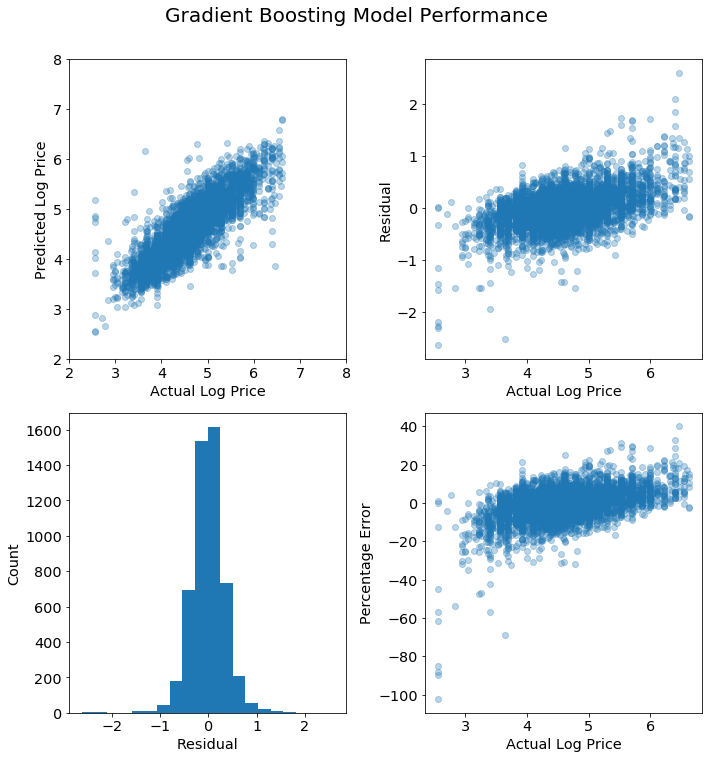

In [224]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,gb_pred_test, alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,gb_residual,alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(gb_residual, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, gb_PE_test,alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('Gradient Boosting Model Performance',y = 1.05, size=20)
plt.tight_layout()
plt.savefig('final_report_figures/gb_diags.png')
plt.show()

In [ ]:
gb_feature_importances = pd.DataFrame({'score':gb.feature_importances_,
                                      'feature': df.drop(['price','log_price'],axis=1).columns})
gb_feature_importances = gb_feature_importances.sort_values('score',ascending=False)[:15]

plt.figure(figsize=(8,5))
sns.barplot(data = gb_feature_importances,y='feature',x='score',color='royalblue')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_report_figures/gb_feat_importance.png');

## 3.6 XGBoost

In [103]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV 

In [104]:
xg = xgb.XGBRegressor(random_state=10, warm_start=True)
xg_param_grid = {'colsample_bytree': [0.5, 0.75, 1], 'n_estimators': [100, 300, 500], 'max_depth': [2, 5], 'gamma':[0,0.1,0.2],
                'eta':[0.1, 0.3, 0.5]}

xg_cv = GridSearchCV(estimator=xg,param_grid=xg_param_grid,cv=5,verbose=1)

In [105]:
xg_cv_start_time = datetime.datetime.now()
xg_cv.fit(X_train, y_train)
xg_cv_end_time = datetime.datetime.now()

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 442.1min finished


In [225]:
(xg_cv_start_time, xg_cv_end_time)

(datetime.datetime(2019, 8, 29, 22, 0, 26, 27888),
 datetime.datetime(2019, 8, 30, 5, 23, 38, 703043))

In [226]:
xg_best_params = xg_cv.best_params_
xg_best_params

{'colsample_bytree': 0.5,
 'eta': 0.1,
 'gamma': 0,
 'max_depth': 5,
 'n_estimators': 500}

In [229]:
xg_cv.cv_results_

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\georg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\georg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\georg\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([  7.64137836,  21.54219146,  34.39045238,  10.95174108,
         31.91228504,  53.24702554,   7.02701845,  20.57798319,
         35.92552848,  11.10272446,  32.52900572,  53.09623075,
          6.97794628,  20.31667695,  33.31412654,  10.61623592,
         31.14114747,  51.67402654,   6.81599321,  19.92952538,
         32.81226311,  10.84103694,  31.81793222,  52.85567408,
          6.98172913,  20.24845834,  33.58618937,  10.8047122 ,
         31.96373606,  53.43631706,   6.96936865,  20.35139093,
         33.62191544,  10.9993885 ,  31.88175721,  54.43503785,
          6.91412473,  20.36017447,  33.81698599,  10.84480534,
         32.08422403,  54.05267868,   7.08368278,  20.52670875,
         34.21151171,  10.97006383,  32.13487282,  53.03597813,
          6.902953  ,  20.36234794,  33.66917062,  10.96866751,
         31.84504056,  52.60652728,   8.16399345,  23.87696815,
         39.61807532,  13.82982221,  40.92578521,  67.91460199,
          7.94238081,  

In [231]:
pd.DataFrame(OrderedDict({'colsample_bytree':xg_cv.cv_results_['param_colsample_bytree'], 
                          'eta': xg_cv.cv_results_['param_eta'],
            'gamma': xg_cv.cv_results_['param_gamma'],
            'max_depth': xg_cv.cv_results_['param_max_depth'],
             'n_estimators': xg_cv.cv_results_['param_n_estimators'],
             'mean_test_score': xg_cv.cv_results_['mean_test_score']})).to_csv('final_report_data/xg_cv_results.csv')

In [233]:
xg = xgb.XGBRegressor(colsample_bytree = xg_best_params['colsample_bytree'], 
                      eta = xg_best_params['eta'],
                      gamma = xg_best_params['gamma'],
                      n_estimators = xg_best_params['n_estimators'],
                 max_depth = xg_best_params['max_depth'],  random_state=RANDOM_STATE)

xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [234]:
xg_pred_test = xg.predict(X_test)
xg_residual = y_test - xg_pred_test
xg_PE_test = np.divide((y_test - xg_pred_test), y_test) *100

xg_test_results = [xg.score(X_test, y_test),np.sqrt(mean_squared_error(y_test, xg_pred_test)),
                  np.mean(np.abs(xg_PE_test))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,xg_test_results):
    print(f'{metric}: {result}')

Test R^2: 0.7300724732092431
Test RMSE: 0.349670442317118
Test AAPE: 5.646757858435134


In [235]:
xg_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(xg_pred_test), np.exp(y_test)) *100

xg_test_results_unlog = [r2_score(np.exp(y_test), np.exp(xg_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(xg_pred_test))), 
                         np.mean(np.abs(xg_PE_test_unlog))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,xg_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.6397612075486095
Test RMSE: 60.68529326617268
Test AAPE: 27.492694194798155


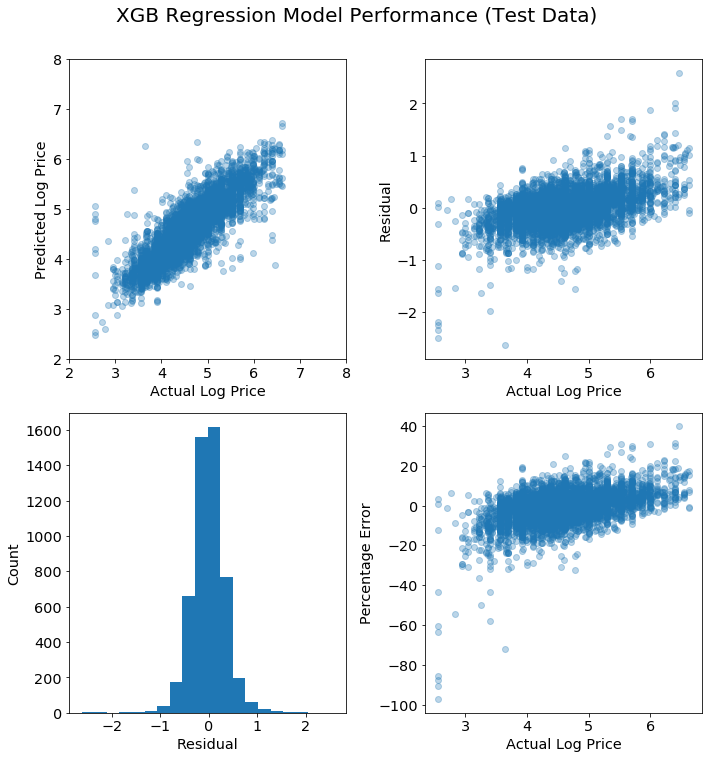

In [236]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,xg_pred_test, alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,xg_residual, alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(xg_residual, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, xg_PE_test, alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('XGB Regression Model Performance (Test Data)',y = 1.05, size=20)
plt.tight_layout()
plt.savefig('final_report_figures/xg_diags.png')
plt.show()

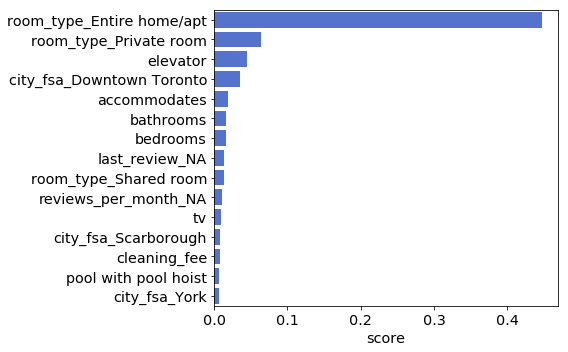

In [237]:
xg_feature_importances = pd.DataFrame({'score':xg.feature_importances_,
                                      'feature': df.drop(['price','log_price'],axis=1).columns})
xg_feature_importances = xg_feature_importances.sort_values('score',ascending=False)[:15]

plt.figure(figsize=(8,5))
sns.barplot(data = xg_feature_importances,y='feature',x='score',color='royalblue')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_report_figures/xg_feat_importance.png');

Based on the model, the most important featuers are room type. Also, in this model, a few of amenities make to the top 20 list. 

## 3.7 Model Comparison

We compare the models based on their performances on predicting both the log price and the actual price.  

In [238]:
summary = OrderedDict({"Linear Regression": lm_test_results, "Random Forest": rf_test_results,
                                   'Gradient Boosting': gb_test_results, "XG Boosting": xg_test_results})
df_model_comparison = pd.DataFrame(summary, index=['R^2','RMSE','AAPE'])
print("Model Performances (Log Price)")
df_model_comparison

Model Performances (Log Price)


,Linear Regression,Random Forest,Gradient Boosting,XG Boosting
R^2,0.654134,0.707773,0.723318,0.730072
RMSE,0.395812,0.363827,0.354018,0.349670
AAPE,6.538311,5.871439,5.706590,5.646758


In [239]:
summary = OrderedDict({"Linear Regression": lm_test_results_unlog, "Random Forest": rf_test_results_unlog,
                                   'Gradient Boosting': gb_test_results_unlog, "XG Boost": xg_test_results_unlog})
df_model_comparison = pd.DataFrame(summary, index=['R^2','RMSE','AAPE'])
print("Model Performances (Price)")
df_model_comparison

Model Performances (Price)


,Linear Regression,Random Forest,Gradient Boosting,XG Boost
R^2,0.468081,0.606448,0.631475,0.639761
RMSE,73.741296,63.429207,61.379283,60.685293
AAPE,32.195190,28.570637,27.789284,27.492694


In [240]:
xg_residual_unlog = np.exp(y_test) - np.exp(xg_pred_test)

In [241]:
df_xg = pd.DataFrame(np.exp(y_test)).merge(pd.DataFrame(np.exp(xg_pred_test),index=y_test.index,columns=['predicted_price']),left_index=True,right_index=True)
df_xg.columns = ['price','predicted_price']
df_xg['residual'] = df_xg.price - df_xg.predicted_price
df_xg['percent_error'] = np.divide(df_xg.price - df_xg.predicted_price,df_xg.price)*100
df_xg['abs_percent_error'] = np.abs(df_xg['percent_error'])

In [242]:
df_xg.head()

,price,predicted_price,residual,percent_error,abs_percent_error
12135,400.0,291.592377,108.407623,27.101906,27.101906
14926,59.0,86.588531,-27.588531,-46.760223,46.760223
168,99.0,128.858521,-29.858521,-30.160122,30.160122
10365,88.0,76.556671,11.443329,13.003783,13.003783
6833,130.0,84.173157,45.826843,35.251418,35.251418


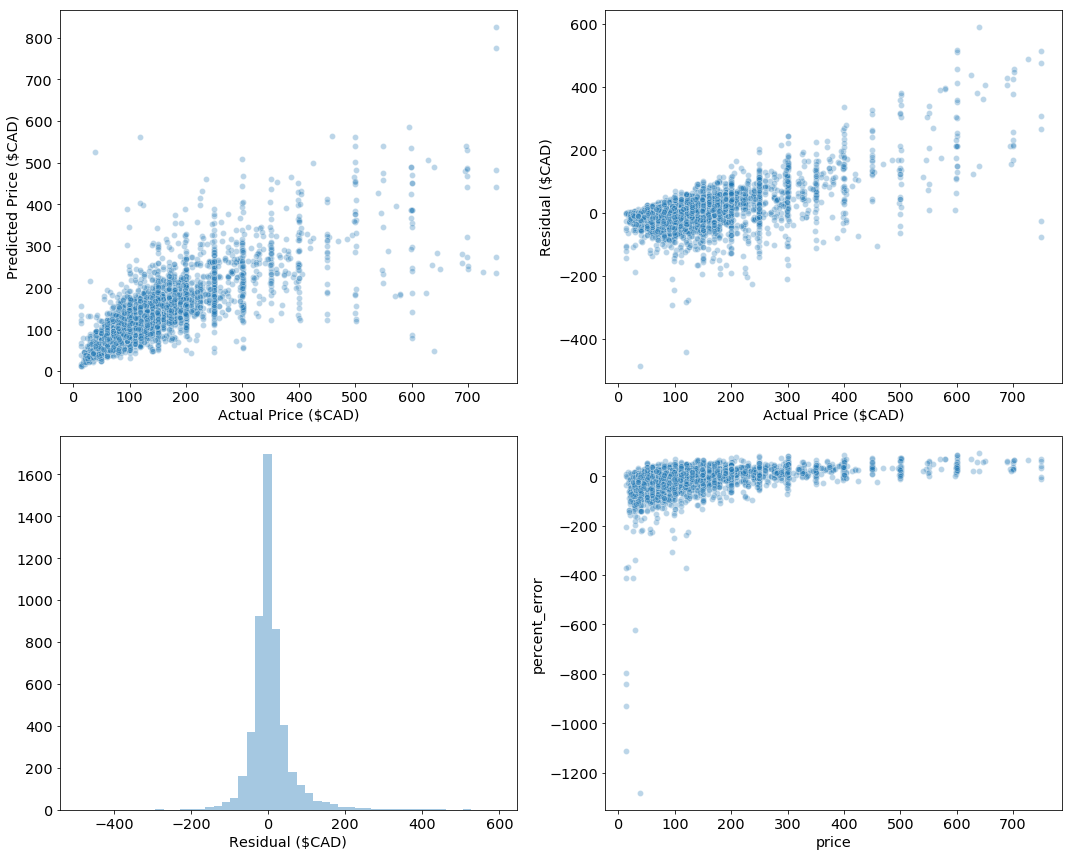

In [244]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.scatterplot(data=df_xg,x='price',y='predicted_price',alpha=0.3)
plt.xlabel('Actual Price ($CAD)')
plt.ylabel('Predicted Price ($CAD)')
plt.subplot(2,2,2)
sns.scatterplot(data=df_xg, x='price',y='residual',alpha=0.3)
plt.xlabel('Actual Price ($CAD)')
plt.ylabel('Residual ($CAD)')
plt.subplot(2,2,3)
sns.distplot(df_xg.residual,kde=False)
plt.xlabel('Residual ($CAD)')
plt.subplot(2,2,4)
sns.scatterplot(data=df_xg, x='price',y='percent_error',alpha=0.3)
plt.tight_layout()
plt.savefig('final_report_figures/xg_diagnostic_unlog.png');

In [245]:
df_xg.to_csv('data/df_xg.csv')

### Interval for residual and absolute percentage error

In [246]:
# residual percentile

np.percentile(df_xg.residual,[2.5,97.5])

array([ -82.08093262,  148.82634544])

In [247]:
np.percentile(df_xg.abs_percent_error,[95])

array([ 71.67514928])

In [183]:
#APE (Not used)
def ape(actual, predicted):
    return (np.divide((actual - predicted), actual) *100)

In [198]:
#results df (Not used)
def results_df(actual_data, predicted_data):
    df_results = pd.DataFrame(actual_data)
    df_results['predicted'] = predicted_data
    df_results['residual'] = df_results.iloc[:,0] - df_results['predicted']
    df_results['pct_error'] = ape(df_results.iloc[:,0], df_results['predicted'])
    return df_results